# Big Data Bowl 
Author: Elizabeth Howell (A02245131) 

Kaggle Competition Link: [link](https://www.kaggle.com/c/nfl-big-data-bowl-2021)

In [ ]:
import os
import pandas as pd
import shutil
import time
from copy import deepcopy
import torch as torch
import torchvision
from torch.utils.data import Dataset, DataLoader,random_split
from torchvision import transforms, utils
import torchvision.models as models
import PIL
from skimage import transform,io
import matplotlib.pyplot as plt
import scipy.ndimage
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
device = 'cuda'
# import models


#Pre-prossessing 

Create a dataset that inherits from the Pytorch Dataset module to make loading data into the network easier. 

In [ ]:
# map of all all possible pass results. 
possible_outcomes = {
    'C':1,
    'I':2,
    'S':3,
    'IN':4,
    'R':5, 
}


In [ ]:
class NFLDataset(Dataset):
  #initialize class
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.outcomes_frame = pd.read_csv(csv_file)
        self.outcomes_frame = self.outcomes_frame[self.outcomes_frame['passResult'].notnull()] # remove any item where label is null
        self.root_dir = root_dir
        self.transform = transform 

    def __len__(self):
        return len(self.outcomes_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        # find path to image where the name is located at row: idx and column:0 in the csv file. 
        # read file and convert image from RGBA to RGB
        img_name = os.path.join(self.root_dir, self.outcomes_frame.iloc[idx, 0]) 
        image = PIL.Image.open(img_name+ str('.png')).convert('RGB')      
        outcome = possible_outcomes[self.outcomes_frame.iloc[idx, 1]] # get pass result from file and map it to it's numerical value 
        return self.transform(image),np.array(outcome), img_name

In [ ]:
# set up tranforms
BATCH = 128
avg_in =(0.4914, 0.4822, 0.4465)
std_in = (0.2023, 0.1994, 0.2010)
data_transforms = {
    'train': transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((56,56)),
    transforms.ToTensor(),
    transforms.Normalize(avg_in, std_in),
    ]),
    'test': transforms.Compose([
    transforms.Resize((56,56)),
    transforms.ToTensor(),
         transforms.Normalize(avg_in, std_in),
    ])
}  # Change 1 update transforms




In [ ]:
#initialize data loaders 
trainset = NFLDataset(csv_file='drive/MyDrive/NFLData/TrainResults.csv', #replace with your own path
                      root_dir='drive/MyDrive/NFLData/TrainData', #replace with your own path
                      transform=data_transforms['train']) 
trainset, valset = random_split(trainset, [12000,4923])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, # Change 2 batch size increase
                                          shuffle=True, num_workers=4) ##
valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH, # Change 2 batch size increase
                                        shuffle=False, )

testset  =  NFLDataset(csv_file='drive/MyDrive/NFLData/TestResults.csv', #replace with your own path
                       root_dir='drive/MyDrive/NFLData/TestData',#replace with your own path
                       transform=data_transforms['test'])
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH,# Change 2 batch size increase
                                         shuffle=False, num_workers=4)



In [ ]:
from IPython import display
def semilogy(filename, x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    """Plot x and log(y)."""

    def set_figsize(figsize=(3.5, 2.5)):
        """Set matplotlib figure size."""
        display.set_matplotlib_formats('svg')
        plt.rcParams['figure.figsize'] = figsize

    set_figsize(figsize)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)
    plt.show()
    plt.savefig(filename)

# Train

In [ ]:
%%time
num_epochs = 10
def trainmodel(model,train_loader, criterion, optimizer, lr_scheduler,filename):
  best_val_acc = -1000
  best_val_model = None
  train_accuracy =[]
  val_accuracy = []
  for epoch in range(num_epochs):
      model.train()
      running_loss = 0.0
      running_acc = 0
      for i, data in enumerate(trainloader,1):
          inputs,labels, imgName = data
          inputs,labels = inputs.cuda(),labels.cuda()
          
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item() * inputs.size(0)
          out = torch.argmax(outputs.detach(),dim=1)
          assert out.shape==labels.shape
           #count the number of correct predictions in batch
          running_acc += (labels==out).sum().item()
      train_accuracy.append(running_acc*100/len(trainset))  
      print(f"Train loss {epoch+1}: {running_loss/len(trainset)},Train Acc:{running_acc*100/len(trainset)}%")
      
      correct = 0
      model.eval()
      with torch.no_grad():
          for inputs, labels,names in valloader:
              out = model(inputs.cuda()).cpu()
              out = torch.argmax(out,dim=1)
              acc = (out==labels).sum().item()
              correct += acc
      print(f"Val accuracy:{correct*100/len(valset)}%")
      val_accuracy.append(correct*100/len(valset))
      if correct>best_val_acc:
          best_val_acc = correct
          best_val_model = deepcopy(model.state_dict())
      lr_scheduler.step()
  #plot accuracies as epochs increase
  semilogy(filename,range(1, num_epochs + 1), train_accuracy, 'epochs', 'accuracy',range(1, num_epochs + 1), val_accuracy,['train', 'valid'])
  print('avg training accuracy: {0}'.format(np.mean(train_accuracy)))
  print('avg validation accuracy: {0}'.format(np.mean(val_accuracy)))
  return best_val_model
      


CPU times: user 16 µs, sys: 1e+03 ns, total: 17 µs
Wall time: 21 µs


#Test 

In [ ]:
%%time
def testmodel(model, test_loader, best_model ):
  out_labels = []
  correct_labels = []
  correct = 0
  model.load_state_dict(best_model)
  model.eval()
  with torch.no_grad():
      for inputs,labels, names in test_loader:
          out = model(inputs.cuda()).cpu()
          out = torch.argmax(out,dim=1) 
          #count the number of correct predictions in batch
          acc = (out==labels).sum().item()
          correct += acc
          out_labels.append(out)
          correct_labels.append(labels)
  print(f"Test accuracy: {correct*100/len(testset)}%")
  return out_labels,correct_labels


CPU times: user 10 µs, sys: 0 ns, total: 10 µs
Wall time: 13.6 µs


#Experiments 

The main models is a ResNeXt-50(32x4d) with the following modifications: 
The network is comprised of a single pretrained ResNeXt-50(32x4d) CNN with the following modifications:

  * The first convolutional layer: 3x3 kernal size, 2x2 stride, and 1x1 padding  
  * The max pool is an Identity layer
  * The fully connected layer (fc) is a sequential layer with the following layers:

      * A Dropout layer 
      * A Linear Layer that outputs 10.

An additional ResNeXt-50(32x4d) model with no additional modifications is used as a control. 

Both models utilize: 
  * Loss Function: Cross Entropy 
  * Optimizer: Adam Optimizer with a weight decay  and learning rate of 1e-5
  * Learning Rate Scheduler: StepLr with step size = 100 and gamma = .01






In [ ]:
# Control Model:  ResNext model - not modificatons 
resnet = models.resnext50_32x4d(pretrained=False)
resnet.fc = nn.Linear(2048, 10)
resnet = resnet.to(device)

resnet_criterion = nn.CrossEntropyLoss()
resnet_optimizer = optim.Adam(resnet.parameters(), weight_decay=1e-5, lr=1e-05)
lr_scheduler = optim.lr_scheduler.StepLR(resnet_optimizer,step_size=100, gamma=0.01)

Train loss 1: 1.3406585833231608,Train Acc:53.2%
Val accuracy:56.42900670322974%
Train loss 2: 1.0095745930671691,Train Acc:58.016666666666666%
Val accuracy:57.48527320739387%
Train loss 3: 0.9822167347272237,Train Acc:58.18333333333333%
Val accuracy:56.611822059719685%
Train loss 4: 0.9664179922739665,Train Acc:58.24166666666667%
Val accuracy:57.586837294332724%
Train loss 5: 0.9547280670801799,Train Acc:58.61666666666667%
Val accuracy:57.16026812918952%
Train loss 6: 0.9473514671325683,Train Acc:58.775%
Val accuracy:57.30245785090392%
Train loss 7: 0.9472468441327413,Train Acc:58.75%
Val accuracy:56.71338614665854%
Train loss 8: 0.9419399778048198,Train Acc:59.041666666666664%
Val accuracy:57.68840138127158%
Train loss 9: 0.9401334640185038,Train Acc:58.78333333333333%
Val accuracy:57.830591102985984%
Train loss 10: 0.9350420627593994,Train Acc:59.09166666666667%
Val accuracy:57.36339630306723%


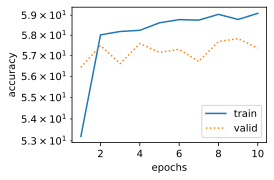

avg training accuracy: 58.07000000000001
avg validation accuracy: 57.217144017875285
Test accuracy: 57.778738115816765%


<Figure size 252x180 with 0 Axes>

In [ ]:
bestmodel = trainmodel(resnet,trainloader, resnet_criterion, resnet_optimizer, lr_scheduler, 'Resnext50' )
output_labels, test_labels=  testmodel(resnet, testloader, bestmodel)

In [91]:
# Actual Model:  ResNext model - modified
resnet2 = models.resnext50_32x4d(pretrained=True)
resnet2.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
resnet2.maxpool = nn.Identity()
resnet2.fc = nn.Sequential(
    nn.Dropout(0.8),
    nn.Linear(2048, 10)
)
resnet2 = resnet2.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet2.parameters(), weight_decay=1e-5, lr=1e-05)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=100, gamma=0.01)
#62.92

Train loss 1: 1.9268538576761882,Train Acc:34.65%
Val accuracy:58.52122689417022%
Train loss 2: 1.2164590927759806,Train Acc:56.00833333333333%
Val accuracy:58.541539711557995%
Train loss 3: 1.0718173821767172,Train Acc:56.358333333333334%
Val accuracy:59.21186268535446%
Train loss 4: 0.9864644948641459,Train Acc:57.86666666666667%
Val accuracy:59.922811293926465%
Train loss 5: 0.9050238397916158,Train Acc:59.50833333333333%
Val accuracy:61.08064188502945%
Train loss 6: 0.851494276046753,Train Acc:62.40833333333333%
Val accuracy:61.38533414584603%
Train loss 7: 0.8146832019488017,Train Acc:63.61666666666667%
Val accuracy:61.446272598009344%
Train loss 8: 0.7798791097005209,Train Acc:65.40833333333333%
Val accuracy:60.83688807637619%
Train loss 9: 0.7358160088857015,Train Acc:68.68333333333334%
Val accuracy:61.365021328458255%
Train loss 10: 0.6850035634040833,Train Acc:71.51666666666667%
Val accuracy:58.13528336380256%


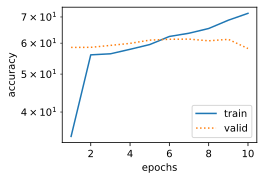

avg training accuracy: 59.6025
avg validation accuracy: 60.044688198253105
Test accuracy: 62.74848746758859%


<Figure size 252x180 with 0 Axes>

In [92]:
bestmodel = trainmodel(resnet2,trainloader, criterion, optimizer, lr_scheduler, 'Modified Resnext50' )
o_labels, c_labels = testmodel(resnet2, testloader, bestmodel )


#Analysis 


In [93]:
no_labels = np.array(torch.cat(o_labels))
nc_labels = np.array(torch.cat(c_labels))
correct_outputs = nc_labels[(torch.cat(o_labels)==torch.cat(c_labels))]


In [101]:
# compare predicted labels vs predicted labels for each pass result type

#Complete pass
all_complete = np.count_nonzero(nc_labels == possible_outcomes['C']) 
cor_C = np.count_nonzero([correct_outputs== possible_outcomes['C']])
p_C= cor_C/all_complete * 100
print('{0} Correctly Predicted Complete Labels \n{1} Total Correct Complete Labels'.format(cor_C, all_complete))
print('{0}% of complete passes correctly predicted'.format(p_C))

#Incomplete pass
all_incomplete = np.count_nonzero(nc_labels == possible_outcomes['I']) 
cor_I = np.count_nonzero([correct_outputs== possible_outcomes['I']])
p_I = cor_I/all_incomplete * 100
print('\n{0} Correctly Predicted Incomplete Labels \n{1} Total Correct Incomplete Labels'.format(cor_I, all_incomplete))
print('{0}% of Incomplete correctly predicted'.format(p_I))

#Sack
all_sack = np.count_nonzero(nc_labels == possible_outcomes['S']) 
cor_S = np.count_nonzero([correct_outputs== possible_outcomes['S']])
p_S = cor_S/all_sack * 100
print('\n{0} Correctly Predicted Sack Labels \n{1} Total Correct Sack Labels'.format(cor_S, all_sack))
print('{0}% of Sacks correctly predicted'.format(p_S))

#Interception
all_IN = np.count_nonzero(nc_labels == possible_outcomes['IN']) 
cor_IN = np.count_nonzero([correct_outputs== possible_outcomes['IN']])
p_IN = cor_IN/all_IN * 100
print('\n{0} Correctly Predicted Interceptions Labels \n{1} Total Correct Interception Labels'.format(cor_IN, all_IN))
print('{0}% of Interception correctly predicted'.format(p_IN))



1253 Correctly Predicted Complete Labels 
1360 Total Correct Complete Labels
92.13235294117646% of complete passes correctly predicted

102 Correctly Predicted Incomplete Labels 
759 Total Correct Incomplete Labels
13.438735177865613% of Incomplete correctly predicted

97 Correctly Predicted Sack Labels 
147 Total Correct Sack Labels
65.98639455782312% of Sacks correctly predicted

0 Correctly Predicted Interceptions Labels 
48 Total Correct Interception Labels
0.0% of Interception correctly predicted


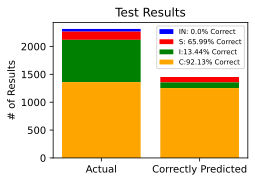

In [98]:
#plot distributions
p_results = ['Actual', 'Correctly Predicted']
complete = np.array([all_complete,cor_C])
incomplete = np.array([all_incomplete, cor_I])
sack = np.array([all_sack,cor_S])
interceptions = np.array([all_IN,cor_IN])
ind = [x for x, _ in enumerate(p_results)]

plt.bar(ind, interceptions, width=.8, label='IN: {0}% Correct'.format(round(p_IN,2)), color='blue', bottom=sack+incomplete+complete)
plt.bar(ind, sack, width=.8, label='S: {0}% Correct'.format(round(p_S,2)), color='red', bottom=incomplete+complete)
plt.bar(ind, incomplete, width=.8, label='I:{0}% Correct'.format(round(p_I,2)), color='green', bottom=complete)
plt.bar(ind, complete, width=.8, label='C:{0}% Correct'.format(round(p_C,2)), color='orange')

plt.xticks(ind, p_results)
plt.ylabel("# of Results")
plt.legend(loc="upper right", fontsize='x-small')
plt.title("Test Results")
plt.savefig('testresults')
plt.show()